# Geospatial Matching Optimization

This project is designed to showcase how to improve the speed of a polygon matching procedure. There are three main areas that could benefit from taking a "geospatial-native" approach:

1. Data encoding and fetching
2. Matching
3. Storage

We will generate synthetic polygon data and use both a non-geospatial-native and geospatial-native approach, comparing execution time for both to see how they differ.

Note: Make sure that you have PostgreSQL running.

## Imports

In [99]:
import random
import uuid
import geopandas as gpd
import pandas as pd
import shapely
from shapely.geometry import Polygon, box
import h3
import time
import helpers as h
import matplotlib.pyplot as plt
from shapely.wkt import dumps, loads
from pathlib import Path
import psycopg2
from psycopg2 import sql
import psutil

# ensure helpers is loaded correctly
import importlib
importlib.reload(h)

Created fresh timing_results.csv
Created fresh timing.log


<module 'helpers' from '/Users/sra/files/projects/matching_optimization/helpers.py'>

## Generate Test Data

In [100]:
@h.timing_decorator
def generate_random_polygons(n=100, bbox=(-180, -90, 180, 90)):
    """Generate n random polygons inside a bounding box with a unique ID."""
    minx, miny, maxx, maxy = bbox
    polygons = []
    ids = []  # List to store UUIDs
    for _ in range(n):
        x1, y1 = random.uniform(minx, maxx), random.uniform(miny, maxy)
        x2, y2 = x1 + random.uniform(1, 2), y1 + random.uniform(1, 2)
        polygons.append(box(x1, y1, x2, y2))  # Create rectangle
        ids.append(str(uuid.uuid4()))  # Generate unique UUID
    gdf = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")
    gdf['id'] = ids  # Add the id column
    return gdf

In [101]:
# Create two months of blob data
prev_month_blobs = generate_random_polygons(n=10000)
curr_month_blobs = generate_random_polygons(n=10000)

Function `generate_random_polygons` executed in 0.2157 sec, CPU: 14.50%, Memory: 25.66MB
Function `generate_random_polygons` executed in 0.2835 sec, CPU: -6.30%, Memory: 36.25MB


In [102]:
prev_month_blobs.head()

,geometry,id
0,"POLYGON ((-75.65241 -60.77747, -75.65241 -59.1...",6dcdfcab-53a0-4d56-9545-cd8593746cdd
1,"POLYGON ((-70.79809 -44.44490, -70.79809 -43.3...",3f854120-92fd-42c3-a49c-1b173a4d3acb
2,"POLYGON ((-51.93116 19.67525, -51.93116 21.013...",db281682-f8da-4411-aec0-167b631df114
3,"POLYGON ((36.09145 -49.99846, 36.09145 -48.872...",793ff18d-4110-4946-8e2c-86c67346dd4a
4,"POLYGON ((51.14117 -86.12844, 51.14117 -84.309...",763658a0-ade7-4c9a-9b5b-f2ba1ffa986c


In [110]:
print(prev_month_blobs.iloc[0])

geometry    POLYGON ((-75.65241129239311 -60.7774653415691...
id                       6dcdfcab-53a0-4d56-9545-cd8593746cdd
Name: 0, dtype: object


In [62]:
# make data folder
Path('data/').mkdir(exist_ok=True)

# save as geoparquet
prev_month_blobs.to_parquet('data/prev_month_blobs.parquet')
curr_month_blobs.to_parquet('data/curr_month_blobs.parquet')

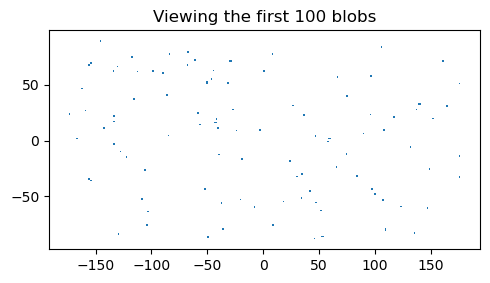

In [63]:
range_ = 100

fig, ax = plt.subplots(figsize=(5, 5))
prev_month_blobs.iloc[0:range_].plot(ax=ax)
ax.set_title(f'Viewing the first {range_} blobs')
plt.tight_layout()

plt.show()

### Make copy of polygon layer and convert to non-geospatial-native string (WKT) datatype

In [64]:
prev_month_blobs_wkt = prev_month_blobs.copy()
curr_month_blobs_wkt = curr_month_blobs.copy()

In [65]:
prev_month_blobs_wkt['geometry'] = prev_month_blobs_wkt['geometry'].apply(dumps)
curr_month_blobs_wkt['geometry'] = curr_month_blobs_wkt['geometry'].apply(dumps)

/var/folders/n3/q8wb235x57n_sx2q14dsngjr0000gn/T/ipykernel_65202/3905694535.py:1: UserWarning: Geometry column does not contain geometry.
  prev_month_blobs_wkt['geometry'] = prev_month_blobs_wkt['geometry'].apply(dumps)
/var/folders/n3/q8wb235x57n_sx2q14dsngjr0000gn/T/ipykernel_65202/3905694535.py:2: UserWarning: Geometry column does not contain geometry.
  curr_month_blobs_wkt['geometry'] = curr_month_blobs_wkt['geometry'].apply(dumps)


### Save in PostgreSQL database

1. Set up a PostgreSQL database
2. Store the WKT-version of the blobs (i.e. as strings, not geometry)

In [75]:
# convert wkt versions to list of tuples for insertion into tables
prev_month_blobs_wkt = list(prev_month_blobs_wkt.itertuples(index=False, name=None))
curr_month_blobs_wkt = list(curr_month_blobs_wkt.itertuples(index=False, name=None))

In [76]:
# Define connection details
postgresql_details = {
    'dbname': 'postgres',  # Use the default database to create the new one
    'user': 'postgres',
    'password': 'rootroot',
    'host': 'localhost',
    'port': '5432'
}

# Step 1: Connect to PostgreSQL and create a new database (if it doesn't exist)
conn = psycopg2.connect(
    dbname=postgresql_details['dbname'],
    user=postgresql_details['user'],
    password=postgresql_details['password'],
    host=postgresql_details['host'],
    port=postgresql_details['port']
)
cur = conn.cursor()

# Commit any active transactions before creating a new database
conn.commit()  # This ensures no open transaction block

# Set autocommit to True for creating the database (it cannot run inside a transaction block)
conn.autocommit = True

# Create a new database (only if it doesn't already exist)
new_db_name = 'blob_matching'
cur.execute(sql.SQL("SELECT 1 FROM pg_database WHERE datname = %s"), [new_db_name])
if not cur.fetchone():
    cur.execute(sql.SQL("CREATE DATABASE {}").format(sql.Identifier(new_db_name)))
    print(f"Database {new_db_name} created.")
else:
    print(f"Database {new_db_name} already exists.")

# Reset autocommit to False (we want to manage transactions for the rest of the operations)
conn.autocommit = False

# Close connection for creating the new database
cur.close()
conn.close()

# Step 2: Connect to the newly created database to create a table
postgresql_details['dbname'] = new_db_name  # Change to the new database
conn = psycopg2.connect(
    dbname=postgresql_details['dbname'],
    user=postgresql_details['user'],
    password=postgresql_details['password'],
    host=postgresql_details['host'],
    port=postgresql_details['port']
)
cur = conn.cursor()

# Create prev_month and curr_month table if it doesn't exist
cur.execute("""
    CREATE EXTENSION IF NOT EXISTS "pgcrypto";
    CREATE TABLE IF NOT EXISTS prev_blobs_wkt (
        geometry TEXT,
        id UUID PRIMARY KEY DEFAULT gen_random_uuid());
    CREATE TABLE IF NOT EXISTS curr_blobs_wkt (
        geometry TEXT,
        id UUID PRIMARY KEY DEFAULT gen_random_uuid());
""")
conn.commit()

# Step 3: Insert WKT strings into the table
cur.executemany('INSERT INTO prev_blobs_wkt (geometry, id) VALUES (%s, %s);', prev_month_blobs_wkt)
cur.executemany('INSERT INTO curr_blobs_wkt (geometry, id) VALUES (%s, %s);', curr_month_blobs_wkt)
conn.commit()

print("Data inserted successfully.")

# Step 4: Retrieve data and convert WKT to geometry
cur.execute("SELECT geometry, id FROM prev_blobs_wkt;")
rows = cur.fetchall()
df_prev = pd.DataFrame(rows, columns=["geometry", "id"])
df_prev["geometry"] = df_prev["geometry"].apply(loads)  # Convert WKT to Shapely geometry
print('df_prev:', df_prev.head())

cur.execute("SELECT geometry, id FROM curr_blobs_wkt;")
rows = cur.fetchall()
df_curr = pd.DataFrame(rows, columns=["geometry", "id"])
df_curr["geometry"] = df_curr["geometry"].apply(loads)  # Convert WKT to Shapely geometry
print('df_curr:', df_curr.head())

# Step 5: Close the connection
cur.close()
conn.close()

Database blob_matching already exists.
Data inserted successfully.
df_prev:                                             geometry  \
0  POLYGON ((-158.5966725744266 26.60522886734023...   
1  POLYGON ((176.21978409511246 -14.9280088021202...   
2  POLYGON ((137.9785558137033 27.41222741599516,...   
3  POLYGON ((-57.580964985751486 23.5397270674304...   
4  POLYGON ((-66.90923725606675 67.10130112202731...   

                                     id  
0  1a954e4a-ccd6-43b4-8a40-0c85055d0174  
1  534f1521-309b-44c2-b4c4-73c1d65f13b6  
2  3dba4ec5-89bc-4a8c-9110-af3937c3ec0b  
3  009b12e8-9002-44fd-b285-06bda955aaf2  
4  09081e2b-cb99-48b5-aa28-8e820ae78bb3  
df_curr:                                             geometry  \
0  POLYGON ((-136.99860799384905 -15.327728065322...   
1  POLYGON ((-88.84855651599074 -65.2365588753379...   
2  POLYGON ((78.38793774218577 22.894964271778974...   
3  POLYGON ((-100.88450978918468 -44.459107566554...   
4  POLYGON ((106.46892154657614 89.44615155659

Baseline - Polygon Matching Only